In [31]:
!pip install matplotlib pandas seaborn numpy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import subprocess
import os
ext=""
if os.name == 'nt':
    ext=".exe"
CUDA_EXEC = "../build/src/cuda/MyProjectCUDA"+ext

current_path = os.getcwd()
naive_path = os.path.join(current_path, "nbody_naive_cuda.csv")
local_mem_path = os.path.join(current_path, "nbody_local_mem_cuda.csv")
bidimensional_path = os.path.join(current_path, "nbody_bidimensional_cuda.csv")
variation_path = os.path.join(current_path, "nbody_variation_cuda.csv")


Se crean funciones auxiliares, best rectangle calcula el mejor rectangulo que puede contener a cierta cantidad de bloques.

In [3]:
import math

#search the best rectangle grid to fit the area given
def best_rectangle(x):
    best_area = float('inf')
    rect = (0, 0)
    for width in range(1, int(math.sqrt(x)) + 2):
        length = math.ceil(x / width)
        area = width * length
        if area >= x and area <= best_area:
            best_area = area
            rect = (width, length)
    return rect

Funcion para ejecuciones de una dimensión, se define con anterioridad para utilizarla varias veces.

In [24]:
# usage -l (optional) <array size> <block size> <grid size> <output file>
def Test_1d(path,localmem:bool=False):
    for i in range(5, 14):
        array_size = 2 ** i
        print(f"Running for array size: {array_size}")
        # for para el tamaño de cada bloque
        for j in range(5,9):
            block_size = 2**j
            #for para la cantidad de bloques
            grid_size = int((array_size+block_size-1)/block_size)
            #10 iteraciones
            for _ in range(10):
                # Construir el comando
                command_CUDA =[CUDA_EXEC,]
                if localmem:
                    command_CUDA+=["-l"]
                command_CUDA+=[
                    str(array_size),
                    str(block_size),
                    str(grid_size),
                    path
                ]
                # Ejecutar el comando
                result = subprocess.run(command_CUDA, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
                # Verificar si hubo algún error en la ejecución
                if result.returncode != 0:
                    print("Error during execution: CUDA")
                    print(result)

En primer lugar se harán los test. Se empezó con la variación de implementación "naive". Se realizaron múltiples test para diferentes valores de: cantidad de cuerpos y cantidad de threads por grupo (local size), diez veces para cada combinación de valores.

In [35]:
Test_1d(naive_path)

Running for array size: 32


Running for array size: 64
Running for array size: 128
Running for array size: 256
Running for array size: 512
Running for array size: 1024
Running for array size: 2048
Running for array size: 4096
Running for array size: 8192


Se siguió con la variación de implementación "local memory" (memoria compartida). se realizaron las mismas pruebas anteriores.

In [32]:
Test_1d(path=local_mem_path,localmem=True)


Running for array size: 32
Running for array size: 64
Running for array size: 128
Running for array size: 256
Running for array size: 512
Running for array size: 1024
Running for array size: 2048
Running for array size: 4096
Running for array size: 8192


Se ejecutaron los mismos test con la variación de implementación "bidimensional" (mapeo en una grilla 2D en el kernel). para cada tamaño de bloque se probaron distintas combinaciones para organizar los valores en rectangulos, luego se calculó la mejor grilla que contuviera los bloques necesarios.

In [37]:
#usage -2 <array size> <block size x> <block size y> <grid size x> <grid size y> <output file>
def Test_2d(path):
    for i in range(5, 14):
        array_size = 2 ** i
        print(f"Running for array size: {array_size}")
        # for para el tamaño de cada bloque
        for j in range(5,9):
            for k in range(0,j+1):
                #for para la cantidad de bloques
                block_size_x=2**k
                block_size_y=2**(j-k)
                grid_size = int((array_size+(2**j)-1)/(2**j))
                grid_size_x,grid_size_y=best_rectangle(grid_size)
                #10 iteraciones
                for _ in range(10):
                    # Construir el comando
                    command_CUDA=[
                        CUDA_EXEC,
                        "-2",
                        str(array_size),
                        str(block_size_x),
                        str(block_size_y),
                        str(grid_size_x),
                        str(grid_size_y),
                        path
                    ]
                    # Ejecutar el comando
                    result = subprocess.run(command_CUDA, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
                    # Verificar si hubo algún error en la ejecución
                    if result.returncode != 0:
                        print("Error during execution: CUDA")
                        print(result)
Test_2d(bidimensional_path)

Running for array size: 32
Running for array size: 64
Running for array size: 128
Running for array size: 256
Running for array size: 512
Running for array size: 1024
Running for array size: 2048
Running for array size: 4096
Running for array size: 8192


Finalmente se ejecutó la prueba en la ejecución de una dimensión sin memoria compartida donde se varian los tamaños de los bloques, se definió una cantidad de particulas fijas y un tamaño de bloque de 256, las pruebas se realizaron aplicando un offset entre -5 y 5 al tamaño de bloque, ejecutando 10 veces cada variación.

In [15]:

# "<array size> <block size> <grid size> <output file>"
def Test_size_variation(path,r):
    array_size = 2**13
    print(f"Running for array size: {array_size}")
    block_size = 128
    for i in range(-r,r+1):
        f_block_size=block_size+i
        #for para la cantidad de bloques
        grid_size = int((array_size+f_block_size-1)/f_block_size)
        #10 iteraciones
        for _ in range(10):
            # Construir el comando
            command_CUDA=[
                CUDA_EXEC,
                str(array_size),
                str(f_block_size),
                str(grid_size),
                path
            ]
            # Ejecutar el comando
            result = subprocess.run(command_CUDA, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
            # Verificar si hubo algún error en la ejecución
            if result.returncode != 0:
                print("Error during execution: CUDA")
                print(result)
Test_size_variation(variation_path,5)

Running for array size: 8192


# Carga de los datos

Se leen los archivos .csv para llevar los datos a dataframes. Se asignan sus columnas de acuerdo a lo que guarda el ejecutable la implementación. Filtramos además aquellas ejecuciones incorrectas no detectadas (con tiempos de ejecución ilógicos).

In [50]:
naive_cuda = pd.read_csv("nbody_naive_cuda.csv", header=None)
local_mem_cuda = pd.read_csv("nbody_local_mem_cuda.csv", header=None)
bidimensional_cuda = pd.read_csv("nbody_bidimensional_cuda.csv", header=None)
variation_cuda = pd.read_csv("nbody_variation_cuda.csv",header=None)

# los tiempos se tomaron en microsegundo
columns1D = ["size", "block size", "grid size", "create data time", "copy to device", "execution time", "copy to host","total time"]
columns2D = ["size", "block size", "block size y", "grid size", "grid size y", "create data time", "copy to device", "execution time", "copy to host","total time"]
naive_cuda.columns = columns1D
local_mem_cuda.columns = columns1D
variation_cuda.columns=columns1D
bidimensional_cuda.columns = columns2D

# Filtrar los DataFrames
naive_cuda_filtered = naive_cuda.query('`execution time` >= 100')
local_mem_cuda_filtered = local_mem_cuda.query('`execution time` >= 100')
variation_cuda_filtered=variation_cuda.query('`execution time` >= 100')
bidimensional_cuda_filtered = bidimensional_cuda.query('`execution time` >= 100')


En primer lugar se muestra un gráfico de linea que muestra la relación entre el tiempo de ejecución vs la cantidad de cuerpos. Este gráfico no toma en cuenta combinaciones de valores de otros atributos, solo tiempos promedios de ejecución por cada versión de la implementación entre todos los test realizados.

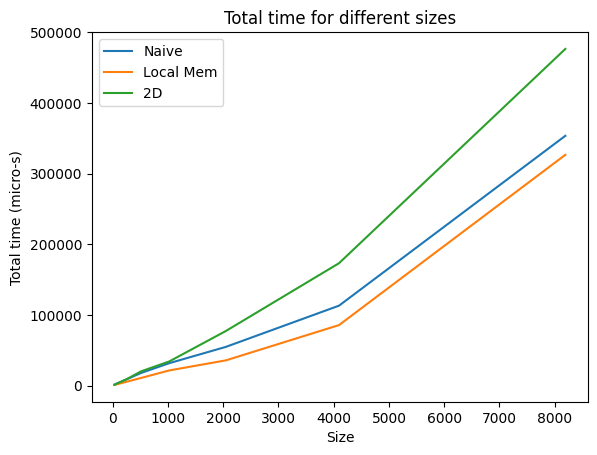

In [35]:
naive_cuda_avg = naive_cuda_filtered.groupby("size").mean()
local_mem_cuda_avg = local_mem_cuda_filtered.groupby("size").mean()
bidimensional_cuda_avg = bidimensional_cuda_filtered.groupby("size").mean()

fig, ax = plt.subplots()
ax.plot(naive_cuda_avg.index, naive_cuda_avg["execution time"], label="Naive")
ax.plot(local_mem_cuda_avg.index, local_mem_cuda_avg["execution time"], label="Local Mem")
ax.plot(bidimensional_cuda_avg.index, bidimensional_cuda_avg["execution time"], label="2D")
ax.set_xlabel("Size")
ax.set_ylabel("Total time (micro-s)")
ax.legend()
plt.title("Total time for different sizes")
plt.show()

Este gráfico es similar al anterior, solo muestra tiempos promedios de ejecución por cada versión de la implementación entre todos los test realizados.

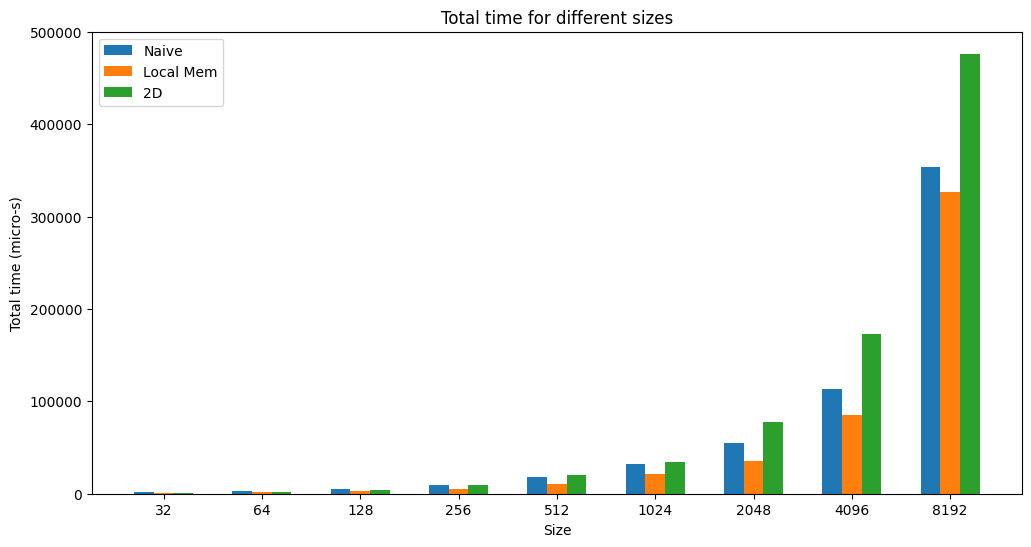

In [36]:
# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.2  # Ancho de las barras

# Posiciones de las barras en el eje x
x = np.arange(len(naive_cuda_avg.index))
# Dibujar las barras
ax.bar(x - width, naive_cuda_avg["execution time"], width, label="Naive")
ax.bar(x, local_mem_cuda_avg["execution time"], width, label="Local Mem")
ax.bar(x + width, bidimensional_cuda_avg["execution time"], width, label="2D")

# Ajustar las etiquetas y el formato del eje x
ax.set_xlabel("Size")
ax.set_ylabel("Total time (micro-s)")
ax.set_xticks(x)
ax.set_xticklabels(naive_cuda_avg.index)
ax.legend()
plt.title("Total time for different sizes")
plt.show()

# Análisis solo NAIVE

Esta versión de la implementación es la inicial, la que realiza los n**2 cálculos accediendo a memoria global, habiendo mapeado los threads en una grilla unidimensional.

In [37]:
naive_local_grouped_data = naive_cuda_filtered.groupby(['size', 'block size'])['execution time'].mean().unstack()

#### Gráfico de Barra para "local size"

Se mostrará en un gráfico de barras la variación en el desempeño de la implementación para los distintos valores de "local size" (threads por grupo) testeados.

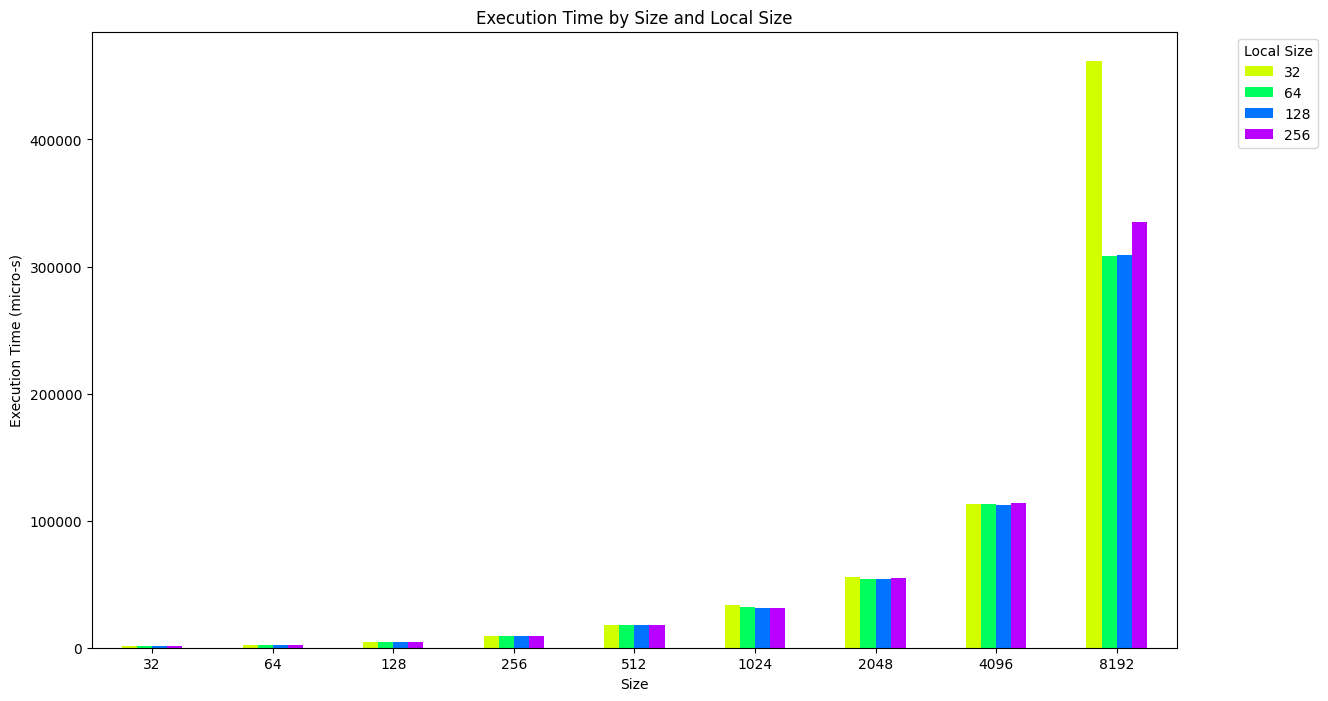

In [42]:
# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(14, 8))

# Configurar colores para cada local size
colors = sns.color_palette("hsv", len(naive_local_grouped_data.columns))

# Plotear cada local size como una barra separada
naive_local_grouped_data.plot(kind='bar', ax=ax, color=colors)

# Configuraciones adicionales del gráfico
ax.set_xlabel("Size")
ax.set_ylabel("Execution Time (micro-s)")
ax.set_title("Execution Time by Size and Local Size")
ax.legend(title="Local Size", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=0)
plt.show()

## Variaciones de Tamaño de grilla

Se muestran los resultados de la ejecución de la variación de tamaños de bloques, promediando las pruebas realizadas de cada tamaño

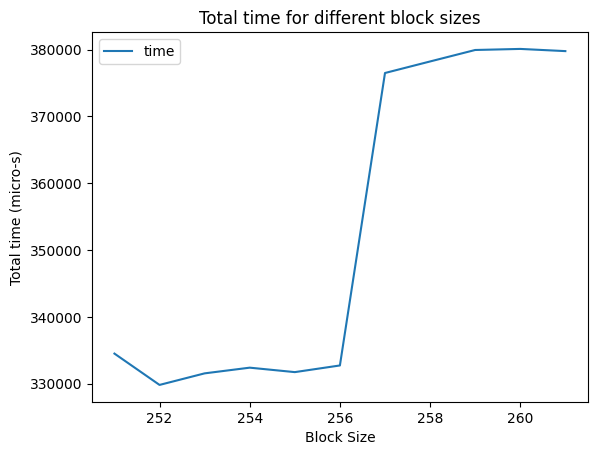

In [20]:
variation_cuda_avg = variation_cuda_filtered.groupby("block size").mean()

fig, ax = plt.subplots()
ax.plot(variation_cuda_avg.index, variation_cuda_avg["execution time"], label="time")
ax.set_xlabel("Block Size")
ax.set_ylabel("Total time (micro-s)")
ax.legend()
plt.title("Total time for different block sizes")
plt.show()

# Análisis solo Memoria Compartida

Esta versión de la implementación es segunda realizada, la que realiza los n**2 cálculos accediendo a memoria global para mover chunks de datos a memoria compartida habiendo mapeado los threads en una grilla unidimensional. Así solo se accede una fracción de veces al arreglo global (dependiendo del tamaño del bloque y del tamaño del arreglo global).

#### Gráfico de barras para "local size"

Se mostrará en un gráfico de barras la variación en el desempeño de la implementación para los distintos valores de "block size" (threads por grupo) testeados, no se tienen todos los tamaños de bloque para tamaños mas grandes pues CUDA limitó la cantidad de bloques con memoria compartida posibles a 32, por lo que las ultimas implementaciones solo corresponden a aquellas que cumplian esta restricción

In [39]:
local_mem_grouped_data = local_mem_cuda_filtered.groupby(['size', 'block size'])['execution time'].mean().unstack()

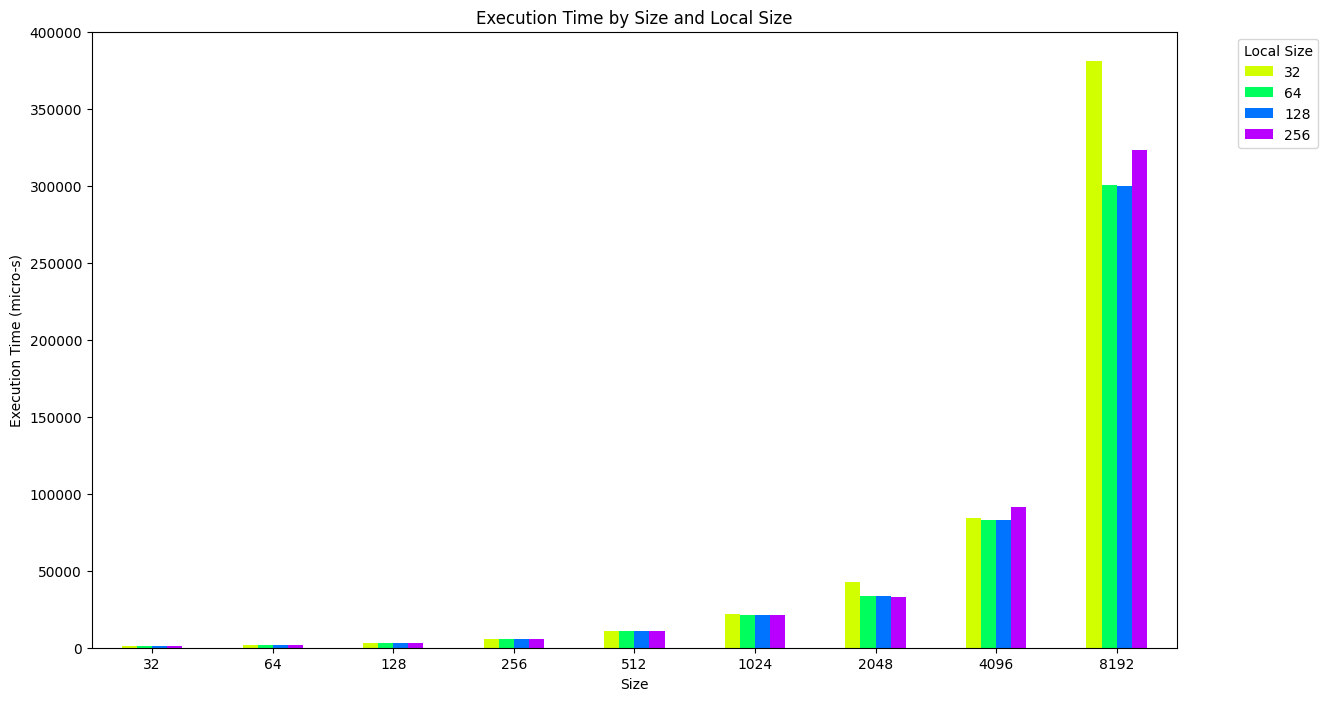

In [40]:
# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(14, 8))

# Configurar colores para cada local size
colors = sns.color_palette("hsv", len(local_mem_grouped_data.columns))

# Plotear cada local size como una barra separada
local_mem_grouped_data.plot(kind='bar', ax=ax, color=colors)

# Configuraciones adicionales del gráfico
ax.set_xlabel("Size")
ax.set_ylabel("Execution Time (micro-s)")
ax.set_title("Execution Time by Size and Local Size")
ax.legend(title="Local Size", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=0)
plt.show()

La variación observada no es según el tamaño determinado para la memoria compartida. Se concluye que para la máquina que ejecutó los test no hay diferencia evidente para los valores utilizados.

# Análisis solo con grupos Bidimensionales

Esta versión de la implementación es la tercera realizada, la que realiza los n**2 cálculos accediendo a memoria global habiendo mapeado los threads en una grilla bidimensional. Esta grilla fue definida con diferentes valores de filas y columnas, esperando encontrar la mejor estructura de mapeo.

#### Pares (global size x, global size y) vs el size

Se mostrará en mapas de calor el tiempo de ejecución promedio de grillas dentro de un grupo (local size x, local size y) para valores específicos de size (cantidad de cuerpos).

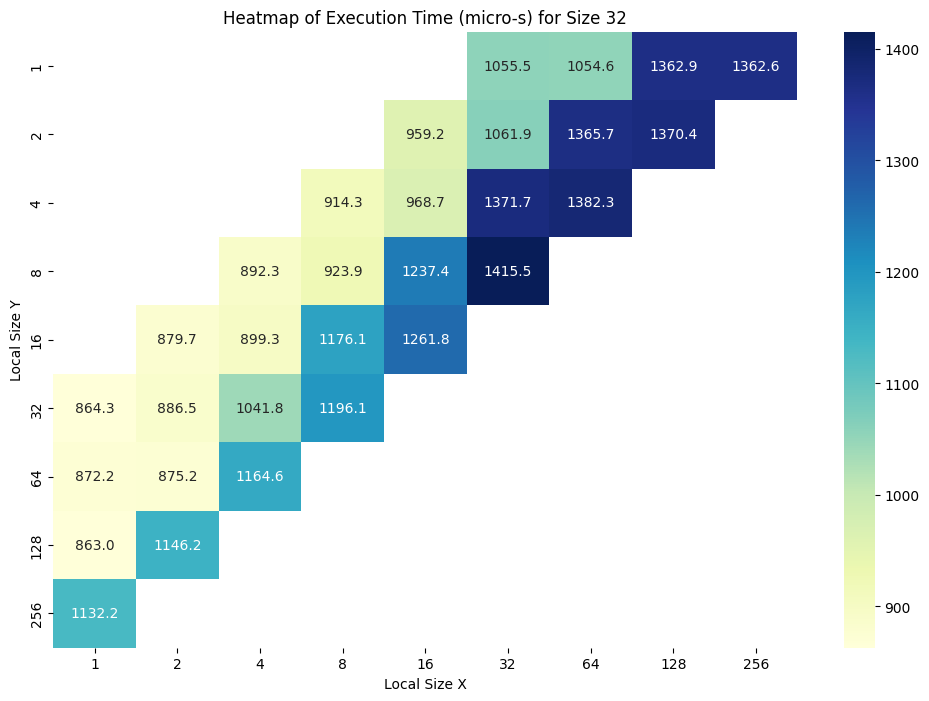

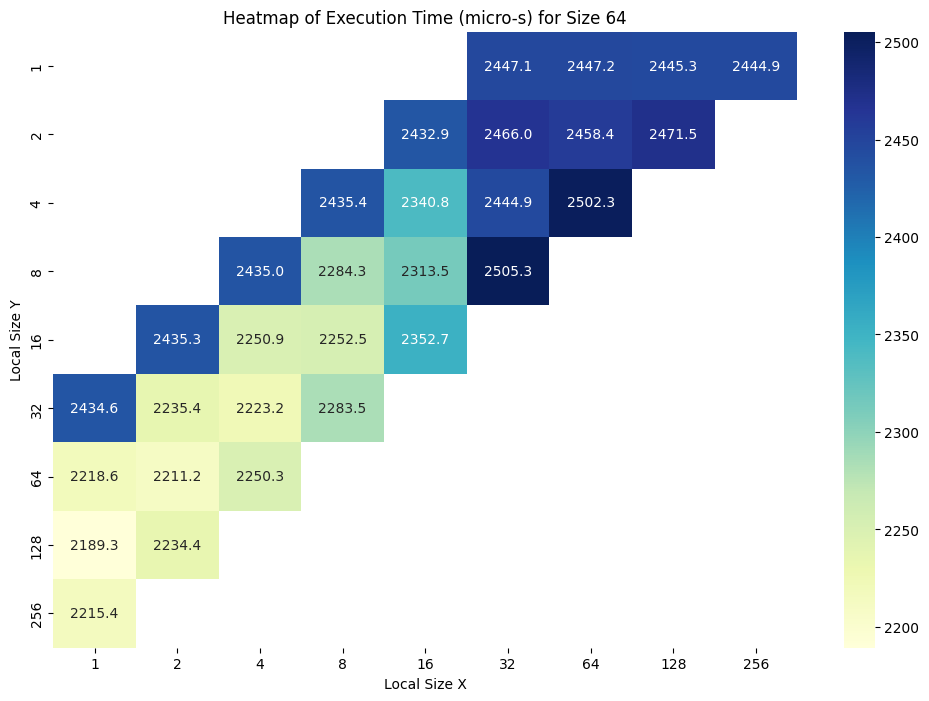

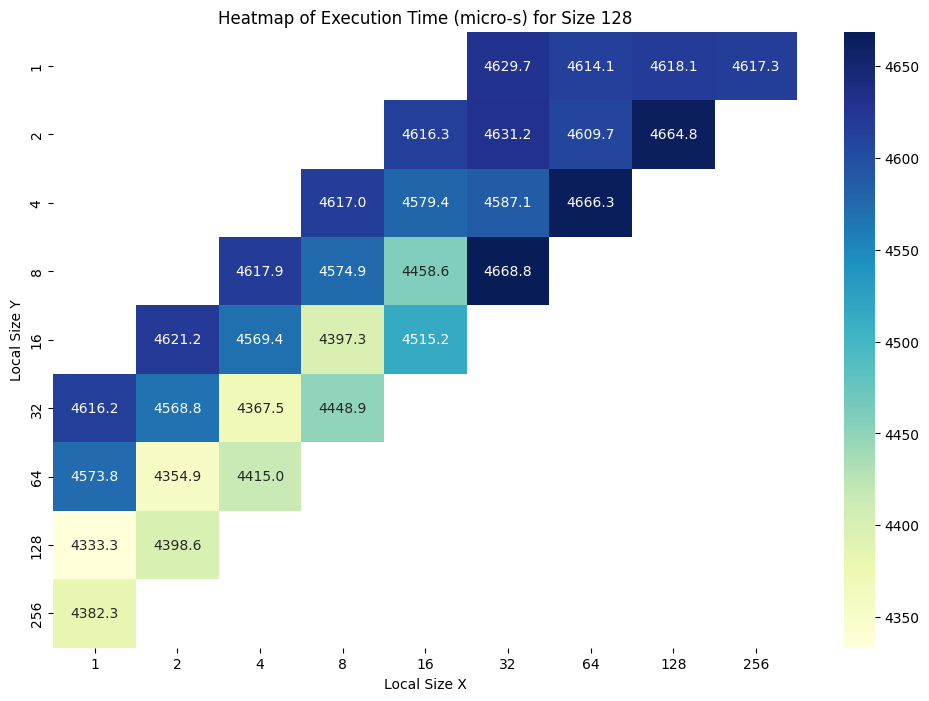

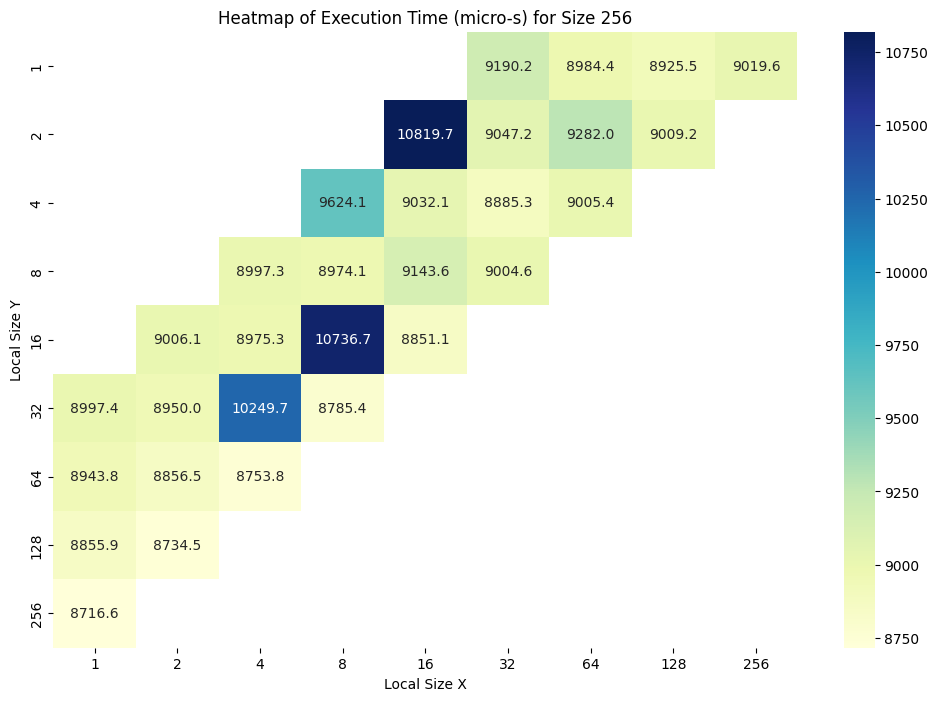

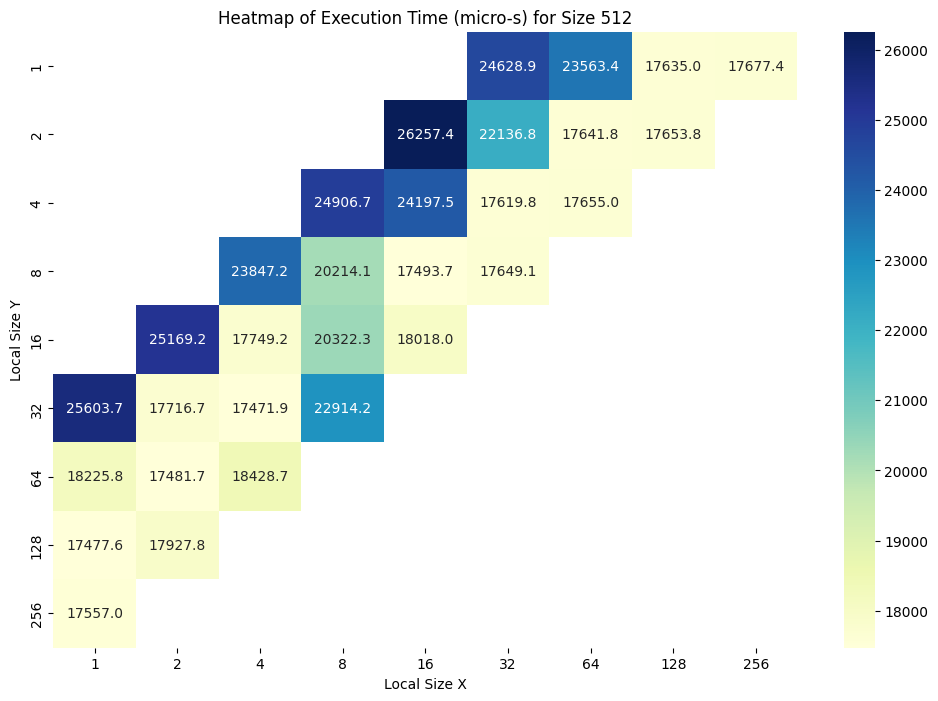

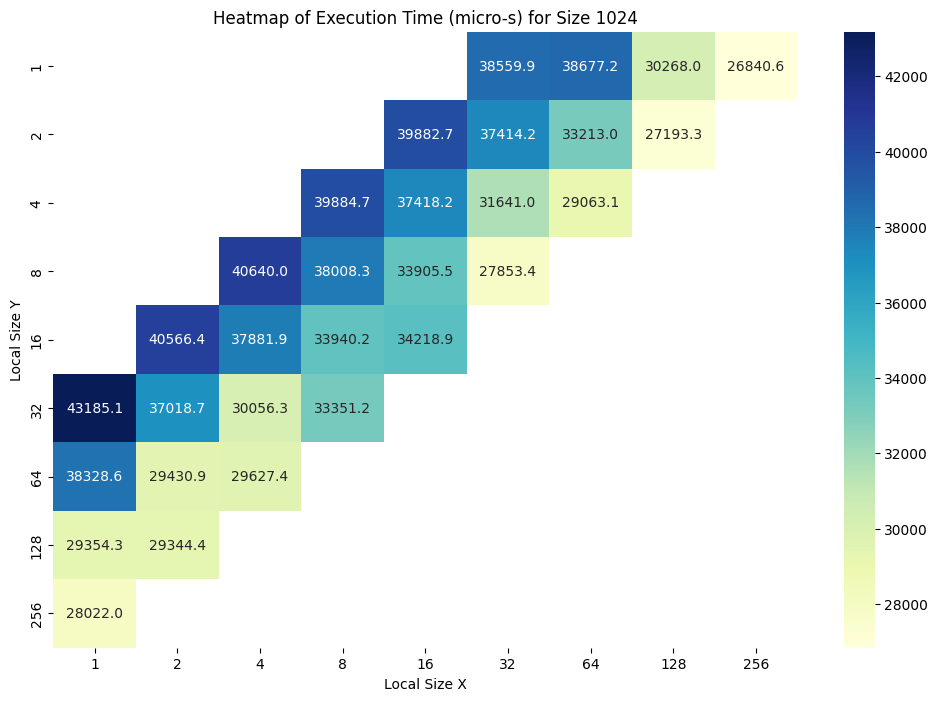

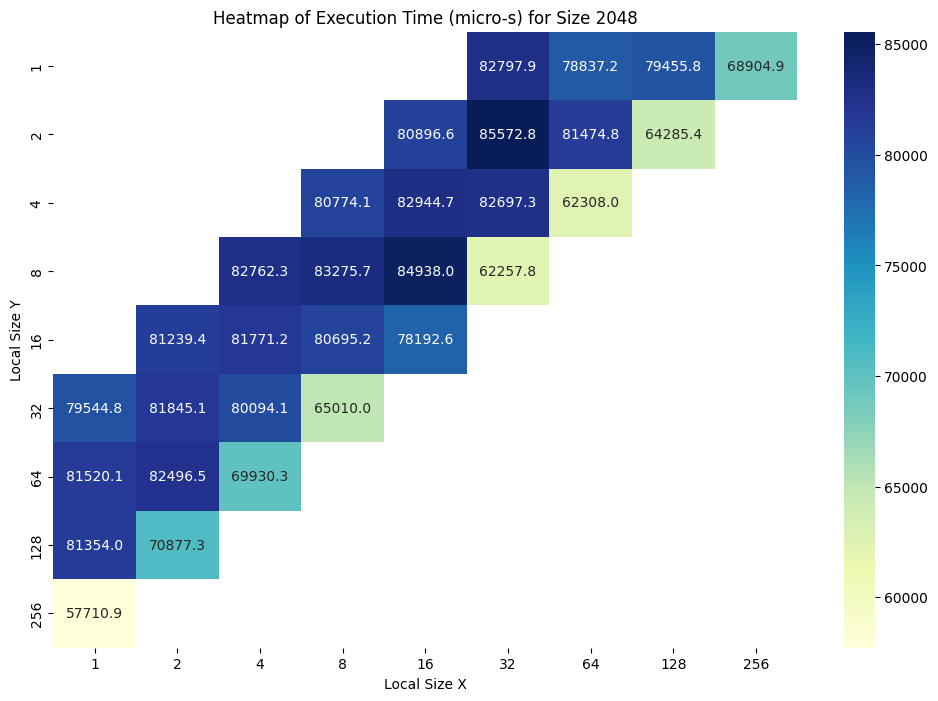

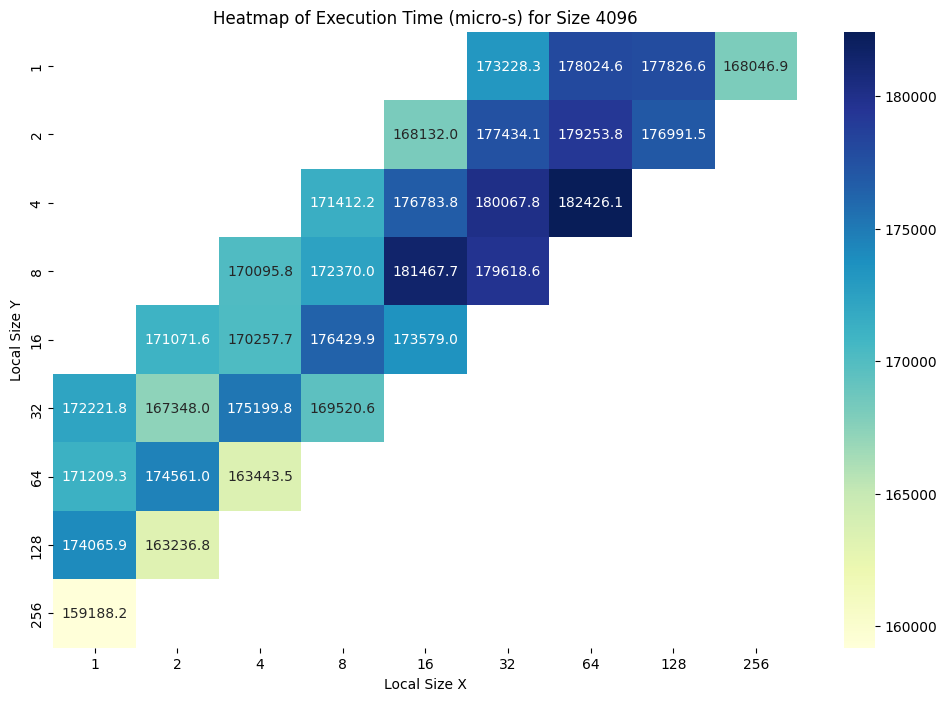

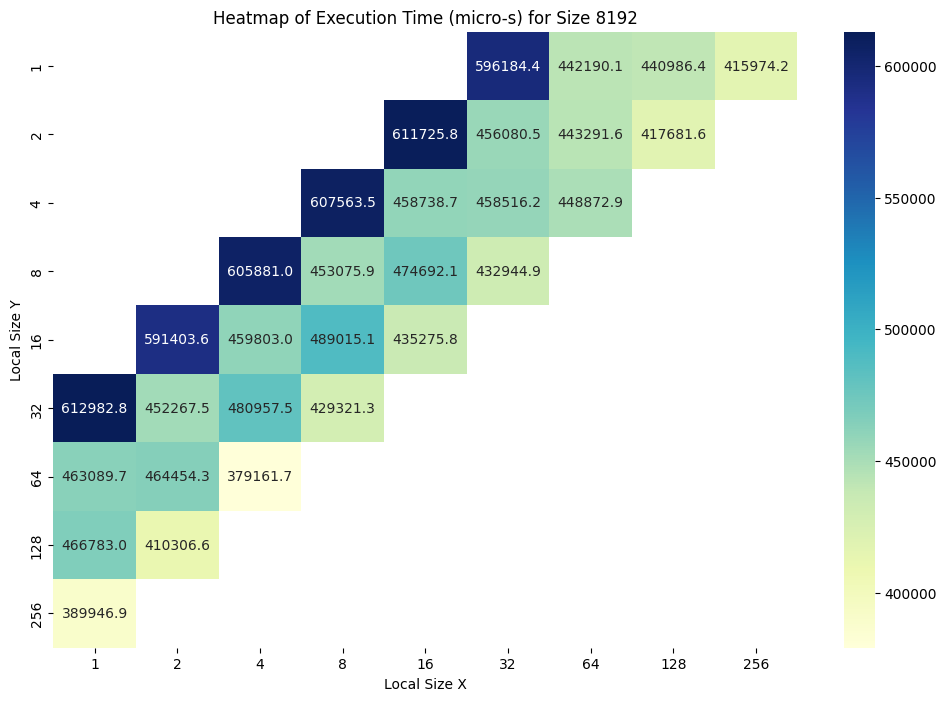

In [52]:
# Obtener los valores únicos de 'size'
unique_sizes = bidimensional_cuda_filtered['size'].unique()

# Crear heatmaps para cada valor de 'size'
for size in unique_sizes:
    # Filtrar los datos por el tamaño actual
    size_data = bidimensional_cuda_filtered[bidimensional_cuda_filtered['size'] == size]
    # Crear una tabla pivot para facilitar el plotting
    pivot_table = size_data.pivot_table(values='execution time', index='block size y', columns='block size', aggfunc='mean')
    # Crear el heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu")
    plt.title(f'Heatmap of Execution Time (micro-s) for Size {size}')
    plt.xlabel('Local Size X')
    plt.ylabel('Local Size Y')
    plt.show()

No se puede detectar un funcionamiento destacable para ninguna de las configuraciones, sin embargo, vemos que se producen problemas al mapear en grillas de 8xLSY (con LSY = local size y) y no se obtnienen resultados útiles.